In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy as sp
import seaborn as sns

# Problem Statement: 

The goal of this data anlaysis is to accurately attribute the type of proposal (Director Election, Spin-Off, Stock Split, etc.) based on the metadata surrounding each proposal and to accurately predict how the proxy voter voted based on the metadata from the data collected for RBC for the 2015 fiscal year. 

## Activist Investors Data Analysis

#### Load the Data

- First step is to load the csv data into a data frame

In [2]:
data = pd.read_csv('training.csv')

In [3]:
data.head()

,Asset Manager,Company,Year,Ticker,Meeting Date,Meeting Type,Security ID,# Management Proposals,Proposal,Bucket,Mgt Rec,Vote,TICKER,NAME,CNTRY_OF_DOMICILE
0,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1a,Elect Director Ronald H. Farmer,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US
1,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1b,Elect Director Colleen A. Goggins,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US
2,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1c,Elect Director Robert A. Ingram,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US
3,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1d,Elect Director Anders O. Lonner,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US
4,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1e,Elect Director Theo Melas-Kyriazi,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18290 entries, 0 to 18289
Data columns (total 15 columns):
Asset Manager             18290 non-null object
Company                   18290 non-null object
Year                      18290 non-null int64
Ticker                    16701 non-null object
Meeting Date              18290 non-null object
Meeting Type              18290 non-null object
Security ID               18290 non-null object
# Management Proposals    18284 non-null object
Proposal                  17933 non-null object
Bucket                    7166 non-null object
Mgt Rec                   17929 non-null object
Vote                      17912 non-null object
TICKER                    18290 non-null object
NAME                      18290 non-null object
CNTRY_OF_DOMICILE         18290 non-null object
dtypes: int64(1), object(14)
memory usage: 2.1+ MB


- Asset Manager: The asset manager associated with the holdings and the proxy vote (In this case it is entirely RBC)
- Company: The company for which the proxy votes were issued
- Year: The year the proxy vote happened
- Ticker: Ticker symbol for the company
- Meeting Date: mm/dd/yyyy for the meeting date of the voting
- Meeting Type: Annual/Quarter etc
- Security ID: Unique Id for the company
- Management Proposals: (1a 2c, etc) The line item in the company release that describes the proposals
- Proposal: A label the company uses to describe the proposal (Spin-off, merger, director election)
- Bucket: An invented column that standardizes the proposal column (Will need to predict this
- Mgt Rec: A variable we can work to predict when we gather more data (States if the management was for or against a proposal 
- Vote: A categorical variable to predict (Identifies if the proxy voter was for or against the action)
- TICKER: Company Ticker
- Company Name
- CNTRY_OF_DOMICILE: Country of Domicile associated with the company

#### Clean the Data

- It seems that there are a lot of rows that are identified as shareholder proposals. The keeper of this spreadsheet would put a empty row to delineate when a proposal switches from a management proposal to a Shareholder proposal. We will have to delete these rows and add a flag that identifies if a proposal is from management or a shareholder

In [5]:
data[data['Proposal'].isnull()].head()

,Asset Manager,Company,Year,Ticker,Meeting Date,Meeting Type,Security ID,# Management Proposals,Proposal,Bucket,Mgt Rec,Vote,TICKER,NAME,CNTRY_OF_DOMICILE
119,RBC Global Asset management,Potash Corporation of Saskatchewan Inc.,2015,POT,12/5/2015,Annual/Special,73755L107,Shareholder proposals,NaN,NaN,NaN,NaN,POT CN,POTASH CORP OF SASKATCHEWAN,CA
252,RBC Global Asset management,Freeport-McMoRan Inc.,2015,FCX,10/6/2015,Annual,35671D857,Shareholder proposals,NaN,NaN,NaN,NaN,FCX US,FREEPORT-MCMORAN INC,US
268,RBC Global Asset management,General Motors Company,2015,GM,9/6/2015,Annual,37045V100,Shareholder proposals,NaN,NaN,NaN,NaN,GM US,GENERAL MOTORS CO,US
287,RBC Global Asset management,Actavis plc,2015,ACT,5/6/2015,Annual,G0083B108,Shareholder proposals,NaN,NaN,NaN,NaN,AGN US,ALLERGAN PLC,US
308,RBC Global Asset management,Wal-Mart Stores Inc.,2015,WMT,5/6/2015,Annual,931142103,Shareholder proposals,NaN,NaN,NaN,NaN,WMT US,WAL-MART STORES INC,US


In [6]:
# create a series to hold the flag for management proposal or shareholder proposal
s = pd.Series(index = data.index,name = 'flag')
# set a variable to store the current company
company = ''
# set a variable to store the current proposal flag
flag = ''
'''Loop over every row in the data frame
   and flag the proposal type
'''
for i,row in data.iterrows():
#   If the proposal contains nan (aka a float type) set the company and the flag 
    if type(row.Proposal) == float:
        company = row.Company
        flag = row['# Management Proposals']
#   If the company set equals the current rows company set the index in the series to the proposal type
    if row.Company == company:
        s[i]=flag
#   else reset the company when the current company doesn't equal the set company
    elif company != '':
        company = ''
#   finally when the company is reset the company has changed and now the proposals are management proposals     
    if company == '':
        s[i] = 'Management Proposal'

In [7]:
s[120] # index 120 should have a shareholder proposal type

'Shareholder proposals'

In [8]:
data['flag'] = s # pull in the flag row into the data frame

In [9]:
data.head() # verify the flag row exits

,Asset Manager,Company,Year,Ticker,Meeting Date,Meeting Type,Security ID,# Management Proposals,Proposal,Bucket,Mgt Rec,Vote,TICKER,NAME,CNTRY_OF_DOMICILE,flag
0,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1a,Elect Director Ronald H. Farmer,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US,Management Proposal
1,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1b,Elect Director Colleen A. Goggins,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US,Management Proposal
2,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1c,Elect Director Robert A. Ingram,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US,Management Proposal
3,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1d,Elect Director Anders O. Lonner,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US,Management Proposal
4,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1e,Elect Director Theo Melas-Kyriazi,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US,Management Proposal


- Now that the proposal flag has been pulled into a separate column we will need to get rid of the rows that have delineated the beginning of a shareholder proposal section.

In [10]:
np.isnan(data[data['# Management Proposals'].isnull()].iloc[1]['Proposal']) # Identify proposal delineation rows

True

In [11]:
df = data.dropna(subset=['Proposal']) # drop any rows that contain NaN values in the Proposals column

- It also looks like the Bucket column for the training set contains some empty values

In [12]:
df[df['Bucket'].isnull()].head()

,Asset Manager,Company,Year,Ticker,Meeting Date,Meeting Type,Security ID,# Management Proposals,Proposal,Bucket,Mgt Rec,Vote,TICKER,NAME,CNTRY_OF_DOMICILE,flag
605,RBC Global Asset management,Crescent Point Energy Corp.,2015,CPG,7/5/2015,Annual/Special,22576C101,4,Amend Restricted Share Bonus Plan,NaN,For,For,CPG CN,CRESCENT POINT ENERGY CORP,CA,Management Proposal
1053,RBC Global Asset management,GLG Life Tech Corporation,2015,GLG,6/26/2015,Annual,361793201,3,Approve Davidson & Company LLP as Auditors and...,NaN,For,For,GLG CN,GLG LIFE TECH CORP,CA,Management Proposal
1062,RBC Global Asset management,The Intertain Group Limited,2015,IT,6/25/2015,Annual/Special,46111Q101,2,Approve BDO LLP as Auditors and Authorize Boar...,NaN,For,Withhold,IT CN,INTERTAIN GROUP LTD/THE,CA,Management Proposal
1063,RBC Global Asset management,The Intertain Group Limited,2015,IT,6/25/2015,Annual/Special,46111Q101,3,Approve Stock Option Plan,NaN,For,Against,IT CN,INTERTAIN GROUP LTD/THE,CA,Management Proposal
1064,RBC Global Asset management,The Intertain Group Limited,2015,IT,6/25/2015,Annual/Special,46111Q101,4,Amend Bylaws,NaN,For,For,IT CN,INTERTAIN GROUP LTD/THE,CA,Management Proposal


Looks like there are about 7000 for training the label classifier

In [13]:
print 'Without Bucket:' + str(len(df[df['Bucket'].isnull()])), 'With Bucket:' + str(len(df[df['Bucket'].notnull()]))

Without Bucket:10767 With Bucket:7166


#### Explore the Data

- How many different companies are there under the data from RBC?
    - Looks like there are about 1500 with Gazprom OAO being the most prominent

In [14]:
#List all the companies in the data frame
print 'Total Number of Companies: ' + str(len(df['Company'].unique()))
df[['Company']].groupby(df['Company']).count().sort_values('Company',ascending=False).head(10)

Total Number of Companies: 1479


,Company
Company,
Gazprom OAO,133
China Construction Bank Corporation,93
Gazprom Oao Moscow,67
Skandinaviska Enskilda Banken,50
China Merchants Bank Co Ltd,47
Paddy Power plc,47
Acs Actividades de Construccion y Servicios S.A,43
Imperial Holdings Ltd,42
Chartwell Retirement Residences,38


- What about the distribution of countries available? 
    - Looks like it is heavily tailed to North American Countries

In [15]:
print 'Number of unique countries: ' + str(df['CNTRY_OF_DOMICILE'].nunique())
print 'List of countries: ' + str(','.join(df['CNTRY_OF_DOMICILE'].unique()))
df[['CNTRY_OF_DOMICILE']].groupby(df['CNTRY_OF_DOMICILE']).count().sort_values('CNTRY_OF_DOMICILE',ascending=False)

Number of unique countries: 54
List of countries: US,CA,#N/A Invalid Security,JP,GB,TW,NL,DE,HK,AU,CH,FR,ES,AR,ID,CN,KR,PH,RU,ZA,IN,MY,JO,TH,GE,IM,PT,FI,IT,IE,JE,IL,SG,BM,AT,NO,MO,SE,PL,CL,LU,NZ,DK,MX,GR,BR,MT,BE,TR,QA,EG,PE,CO,AE


,CNTRY_OF_DOMICILE
CNTRY_OF_DOMICILE,
US,5203
CA,2342
JP,2255
#N/A Invalid Security,1538
GB,1075
CN,476
CH,397
ZA,389
FR,388


- How about years?

In [16]:
df[['Year']].groupby(df['Year']).count().sort_values('Year',ascending=False).head(10)

,Year
Year,
2015,12128
2016,5805


- Graph because we can:

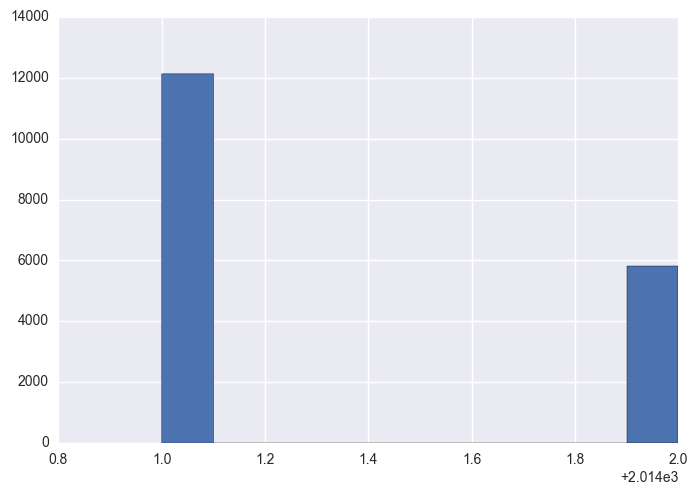

In [17]:
df['Year'].hist();

- What about meeting type?
    - It looks like the majority of meetings fall under some type of annual meeting
    - It is a tailed distribution like country

,Meeting Type
Meeting Type,
Annual,13915
Annual/Special,1399
Annual General Meeting,1390
Special,619
Annual and Special Meeting,238
Proxy Contest,92
Annual & Special Mtg,81
ExtraOrdinary General Meeting,78
Ordinary General Meeting,61


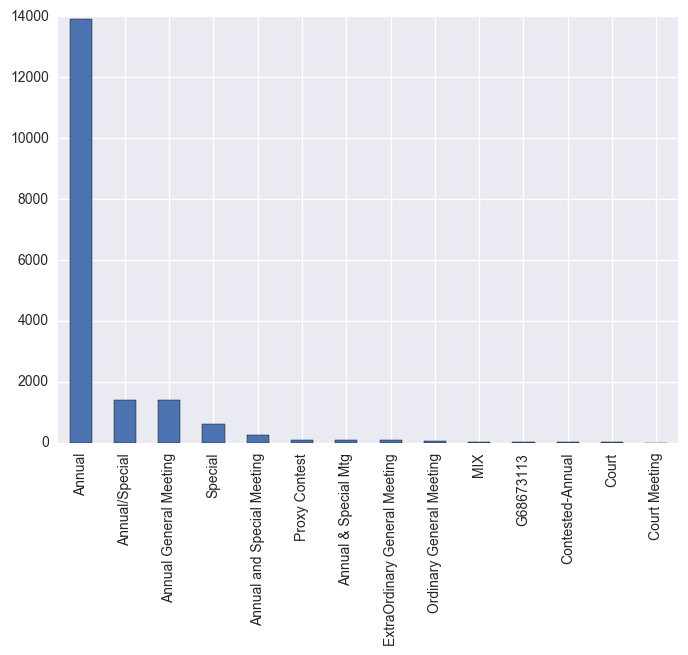

In [18]:
df['Meeting Type'].value_counts().plot(kind='bar');
df[['Meeting Type']].groupby(df['Meeting Type']).count().sort_values('Meeting Type',ascending=False).head(10)

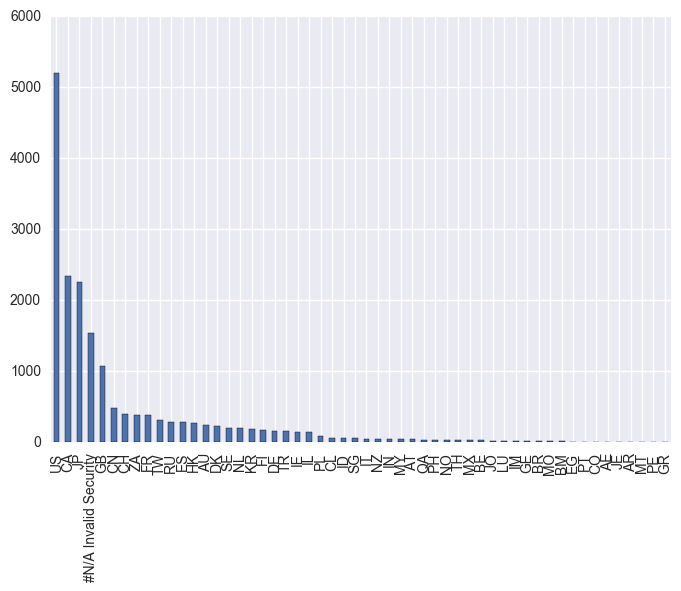

In [19]:
# df[['CNTRY_OF_DOMICILE']].groupby(df['CNTRY_OF_DOMICILE']).count().\
# sort_values('CNTRY_OF_DOMICILE',ascending=False).plot(kind='bar')
df.CNTRY_OF_DOMICILE.value_counts().plot(kind='bar');

#### Create Training Set
- This will only include rows that have a value in the bucket column as we will be training off the the bucket column

In [20]:
train = df.dropna(subset=['Bucket'])

- Looks like the distribution of countries has stayed the same

In [21]:
train.groupby('CNTRY_OF_DOMICILE').size().sort_values(ascending=False)

CNTRY_OF_DOMICILE
US                       3347
CA                       1727
JP                       1111
#N/A Invalid Security     713
IE                         53
CH                         27
GB                         23
HK                         20
FI                         15
CN                         15
DE                         14
FR                         12
NL                         10
AU                          9
ID                          7
AR                          6
JE                          6
DK                          6
CO                          5
TR                          5
TH                          4
SG                          4
BE                          3
ES                          3
SE                          3
MY                          3
IL                          2
IN                          2
CL                          2
PL                          1
RU                          1
IT                          1
QA                    

- Different Countries have different proposal and proxy rules...
    - Let's stick to what we know (the US) and filter the data to the US

In [22]:
train = train[train['CNTRY_OF_DOMICILE']=='US']

In [23]:
len(train)

3347

- Now, we need to get insight into the distribution of the available labels in our training set to help bucket the proposal types

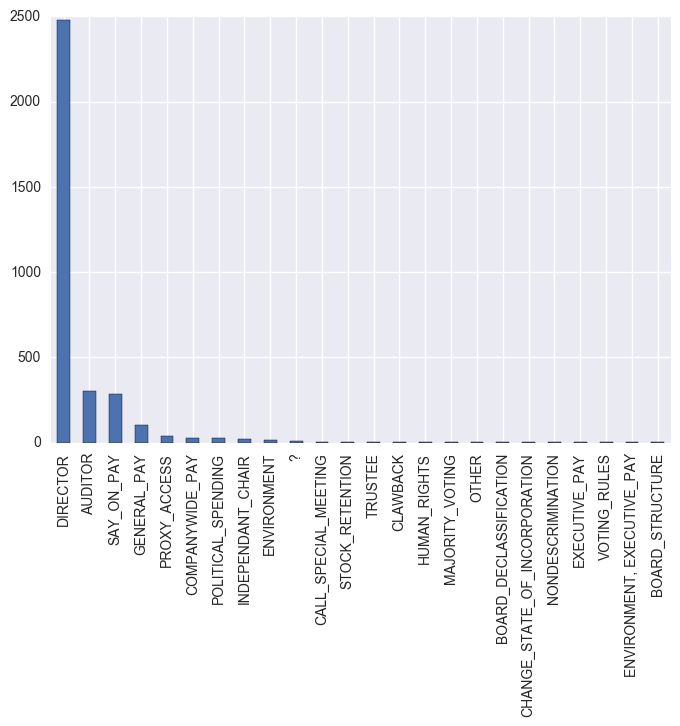

In [24]:
train.Bucket.value_counts().plot(kind='bar');

#### Label Analysis
- Safe to say... I don't like the looks of that.
- The distribution shows that most of these data is labeled as Director
- I will need to label a more diverse set to train my categorization algorithm against the proposal type. 

#### Predict Management Recommendation and Vote Direction
Let's look at the data in a different way:

We need to predict how the management will vote based on metadata attributed to each proposal. 

Let's see if we can gather some extra categorical dummy variables and graph the correlations

In [25]:
dum = pd.get_dummies(train.flag)
train[dum.columns]=dum

In [26]:
train.head()

,Asset Manager,Company,Year,Ticker,Meeting Date,Meeting Type,Security ID,# Management Proposals,Proposal,Bucket,Mgt Rec,Vote,TICKER,NAME,CNTRY_OF_DOMICILE,flag,Dissident Proxy (Blue Card),Management Proposal,Management proposals,Shareholder proposals
0,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1a,Elect Director Ronald H. Farmer,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US,Management Proposal,0,1,0,0
1,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1b,Elect Director Colleen A. Goggins,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US,Management Proposal,0,1,0,0
2,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1c,Elect Director Robert A. Ingram,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US,Management Proposal,0,1,0,0
3,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1d,Elect Director Anders O. Lonner,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US,Management Proposal,0,1,0,0
4,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1e,Elect Director Theo Melas-Kyriazi,DIRECTOR,For,For,VRX CN,VALEANT PHARMACEUTICALS INTE,US,Management Proposal,0,1,0,0


In [27]:
mgt= pd.get_dummies(train['Mgt Rec'],prefix='MGT')

In [28]:
vote = pd.get_dummies(train['Vote'],prefix='VOTE')

In [29]:
train[mgt.columns] = mgt
train[vote.columns] = vote

In [30]:
train.head()

,Asset Manager,Company,Year,Ticker,Meeting Date,Meeting Type,Security ID,# Management Proposals,Proposal,Bucket,...,Management Proposal,Management proposals,Shareholder proposals,MGT_Against,MGT_For,MGT_None,VOTE_Against,VOTE_Did Not Vote,VOTE_For,VOTE_Withhold
0,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1a,Elect Director Ronald H. Farmer,DIRECTOR,...,1,0,0,0,1,0,0,0,1,0
1,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1b,Elect Director Colleen A. Goggins,DIRECTOR,...,1,0,0,0,1,0,0,0,1,0
2,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1c,Elect Director Robert A. Ingram,DIRECTOR,...,1,0,0,0,1,0,0,0,1,0
3,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1d,Elect Director Anders O. Lonner,DIRECTOR,...,1,0,0,0,1,0,0,0,1,0
4,RBC Global Asset management,Valeant Pharmaceuticals International Inc.,2015,VRX,5/19/2015,Annual,91911K102,1e,Elect Director Theo Melas-Kyriazi,DIRECTOR,...,1,0,0,0,1,0,0,0,1,0


In [31]:
cor = train.corr()

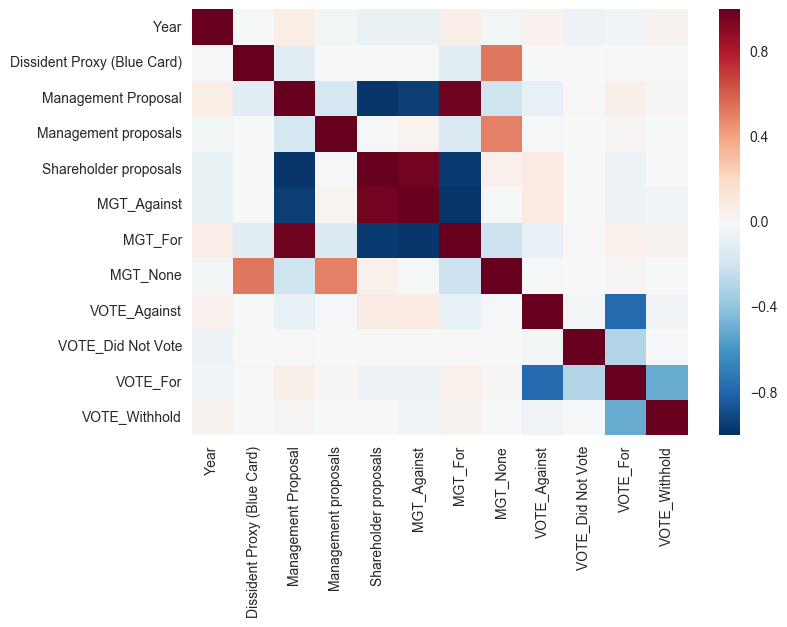

In [32]:
sns.heatmap(cor);

#### Quick Correlation Heatmap Review

It looks like the highest correlations arise when the shareholders make a proposal. The heatmap suggests that management will most likely disagree with a shareholder proposal... Which makes sense. You wouldn't necessarily want shareholders taking control of your board. 